1. The dataset comes from a real world manufacturing process of a Critical Manufacturing business partner. The manufacturing process is monitored via a IoT system. Eight different readings are taken each time a particular tool is used. Eventually once a tool begins underperforming, it is retired and therefore does not again again appear in the dataset. We believe that this dataset may be used to estimate and predict tool longevity, as it likely presents time dependent covariates as such be of use to the research of multilevel survival analysis or predictive maintenance models.

In [1]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import tensorflow as tf
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from skopt import BayesSearchCV
from sklearn.svm import OneClassSVM


C:\Users\Alam Rithika\anaconda3\envs\MLDP_P01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
file_path = 'data.csv'
data = pd.read_csv(file_path)

In [3]:
# Display the first few rows of the dataset
print(data.head())

   Index  OperationEndTime  ToolId  Machine  Process  P1DataPoint1  \
0      0                 0       0        0        0         2.470   
1      1                15       1        1        1        -0.492   
2      2                85       0        0        0        -2.470   
3      3               114       2        2        2         0.493   
4      4               228       0        0        0         1.482   

   P1DataPoint2  P2DataPoint1  P2DataPoint2  P3DataPoint1  ...  P4DataPoint1  \
0         2.964         1.482         0.988         7.904  ...         3.952   
1         0.984        -4.432         8.864         1.970  ...         1.970   
2         4.940        -0.988         2.470         1.976  ...         7.904   
3         0.000        -1.974         1.481         2.961  ...         3.948   
4         3.952        -0.494         0.494         3.952  ...         4.940   

   P4DataPoint2  P5DataPoint1  P5DataPoint2  P6DataPoint1  P6DataPoint2  \
0         0.988        

In [4]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100880 entries, 0 to 100879
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Index             100880 non-null  int64  
 1   OperationEndTime  100880 non-null  int64  
 2   ToolId            100880 non-null  int64  
 3   Machine           100880 non-null  int64  
 4   Process           100880 non-null  int64  
 5   P1DataPoint1      100880 non-null  float64
 6   P1DataPoint2      100858 non-null  float64
 7   P2DataPoint1      100880 non-null  float64
 8   P2DataPoint2      100858 non-null  float64
 9   P3DataPoint1      100880 non-null  float64
 10  P3DataPoint2      100858 non-null  float64
 11  P4DataPoint1      100880 non-null  float64
 12  P4DataPoint2      100858 non-null  float64
 13  P5DataPoint1      100880 non-null  float64
 14  P5DataPoint2      100858 non-null  float64
 15  P6DataPoint1      100880 non-null  float64
 16  P6DataPoint2      10

In [5]:
# Display basic statistics of the dataset
print(data.describe())

               Index  OperationEndTime         ToolId        Machine  \
count  100880.000000      1.008800e+05  100880.000000  100880.000000   
mean    50439.500000      5.768154e+06     930.029946       0.907197   
std     29121.691915      3.610247e+06     546.974343       0.832014   
min         0.000000      0.000000e+00       0.000000       0.000000   
25%     25219.750000      2.619229e+06     445.000000       0.000000   
50%     50439.500000      5.665242e+06     947.000000       1.000000   
75%     75659.250000      8.492686e+06    1408.000000       2.000000   
max    100879.000000      1.253880e+07    1855.000000       2.000000   

             Process   P1DataPoint1   P1DataPoint2   P2DataPoint1  \
count  100880.000000  100880.000000  100858.000000  100880.000000   
mean        1.009625       0.026527       1.515813       0.037269   
std         1.188879       1.400492       1.443985       1.476443   
min         0.000000      -8.865000       0.000000      -8.892000   
25%   

In [6]:
data.shape

(100880, 21)

### 1. Data Cleaning

In [7]:
# 1. Handling Missing Values
missing_values = data.isnull().sum()

In [8]:
# Display such values
print("Missing Values:\n", missing_values)

Missing Values:
 Index                0
OperationEndTime     0
ToolId               0
Machine              0
Process              0
P1DataPoint1         0
P1DataPoint2        22
P2DataPoint1         0
P2DataPoint2        22
P3DataPoint1         0
P3DataPoint2        22
P4DataPoint1         0
P4DataPoint2        22
P5DataPoint1         0
P5DataPoint2        22
P6DataPoint1         0
P6DataPoint2        22
P7DataPoint1         0
P7DataPoint2        22
P8DataPoint1         0
P8DataPoint2        22
dtype: int64


In [9]:
# Filter Rows with Missing Values
rows_with_missing_values = data[data.isnull().any(axis=1)]
print("Rows with Missing Values:\n", rows_with_missing_values)

Rows with Missing Values:
          Index  OperationEndTime  ToolId  Machine  Process  P1DataPoint1  \
3845      3845            361398      62        2        1        -1.974   
4931      4931            474751      84        1        1         0.000   
4945      4945            485751      85        2        4         0.000   
5114      5114            503471      91        2        1         0.000   
6848      6848            615700     119        1        3         0.000   
12886    12886           1248835     212        1        1         0.000   
39028    39028           4283431     718        2        0         0.987   
46856    46856           5338779     885        2        3        -0.493   
46862    46862           5339599     886        1        3        -0.492   
50238    50238           5651320     945        2        1         1.974   
52245    52245           5898135     979        1        1        -4.925   
61942    61942           6790420    1155        1        5   

From the rows with missing values, it seems that certain columns have consistent missing entries. Here are some observations and patterns:

- Consistent Missing Columns: P1DataPoint2, P2DataPoint2, P3DataPoint2, P4DataPoint2, P5DataPoint2, P6DataPoint2, P7DataPoint2, P8DataPoint2 are consistently missing across these rows.

- Specific Rows with Missing Data: The missing data spans a variety of ToolId, Machine, and Process combinations, which might suggest the missingness is not isolated to a specific tool or machine but more broadly distributed.

- Moreover, since there is only 22 rows of missing values which is not significantly alot, having them removed is the best option.

In [10]:
# Drop rows with missing values
data=data.dropna()

- Before, there was a total of 100880 rows, after removing, there are 100858 rows. Exactly redcued by 22. 

In [11]:
# 2. Check for any duplicates 

In [12]:
# Check for duplicates
duplicates = data[data.duplicated(keep=False)]

# Display results
if duplicates.empty:
    print("No duplicates found.")
else:
    print("Rows with duplicates:")
    print(duplicates)

No duplicates found.


### Data Exploration & Visualization

1. P1DataPoint2, P8DataPoint2. These columns represent the error metrics associated with each primary column (P1DataPoint1, P8DataPoint2). Meaning that these columns measure the  accuracy and reliability of the primary columns. Primary columns can be of different readings like temperature readings, pressure and etc. 


2. Whether to build single/multiple anomaly detection models:
- If different machines show significantly different patterns and distributions, it may be beneficial to build different anomaly detection. If overall patterns are similar, a single model might suffice. 

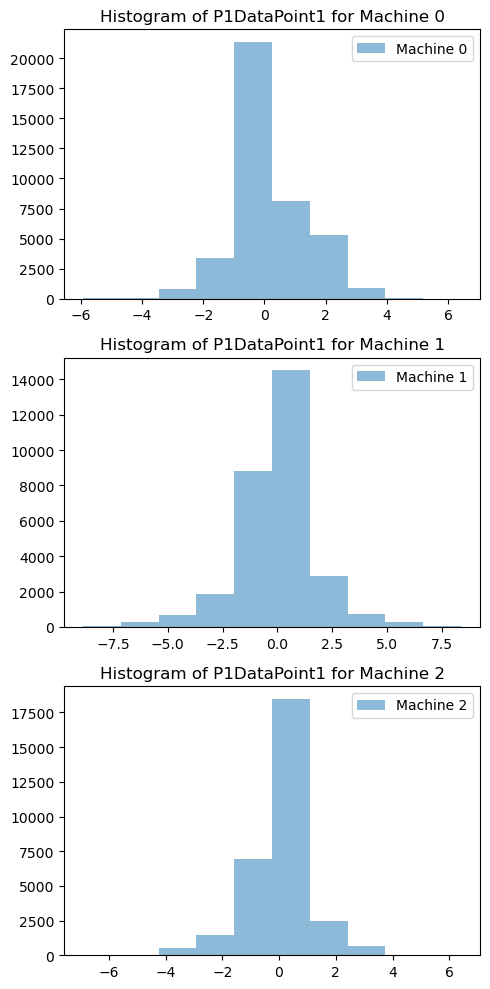

In [13]:
machines = data['Machine'].unique()

fig, ax = plt.subplots(len(machines), figsize=(5, 10))

for i, machine in enumerate(machines):
    ax[i].hist(data[data['Machine'] == machine]['P1DataPoint1'], alpha=0.5, label=f'Machine {machine}')
    ax[i].set_title(f'Histogram of P1DataPoint1 for Machine {machine}')
    ax[i].legend()

plt.tight_layout()
plt.show()


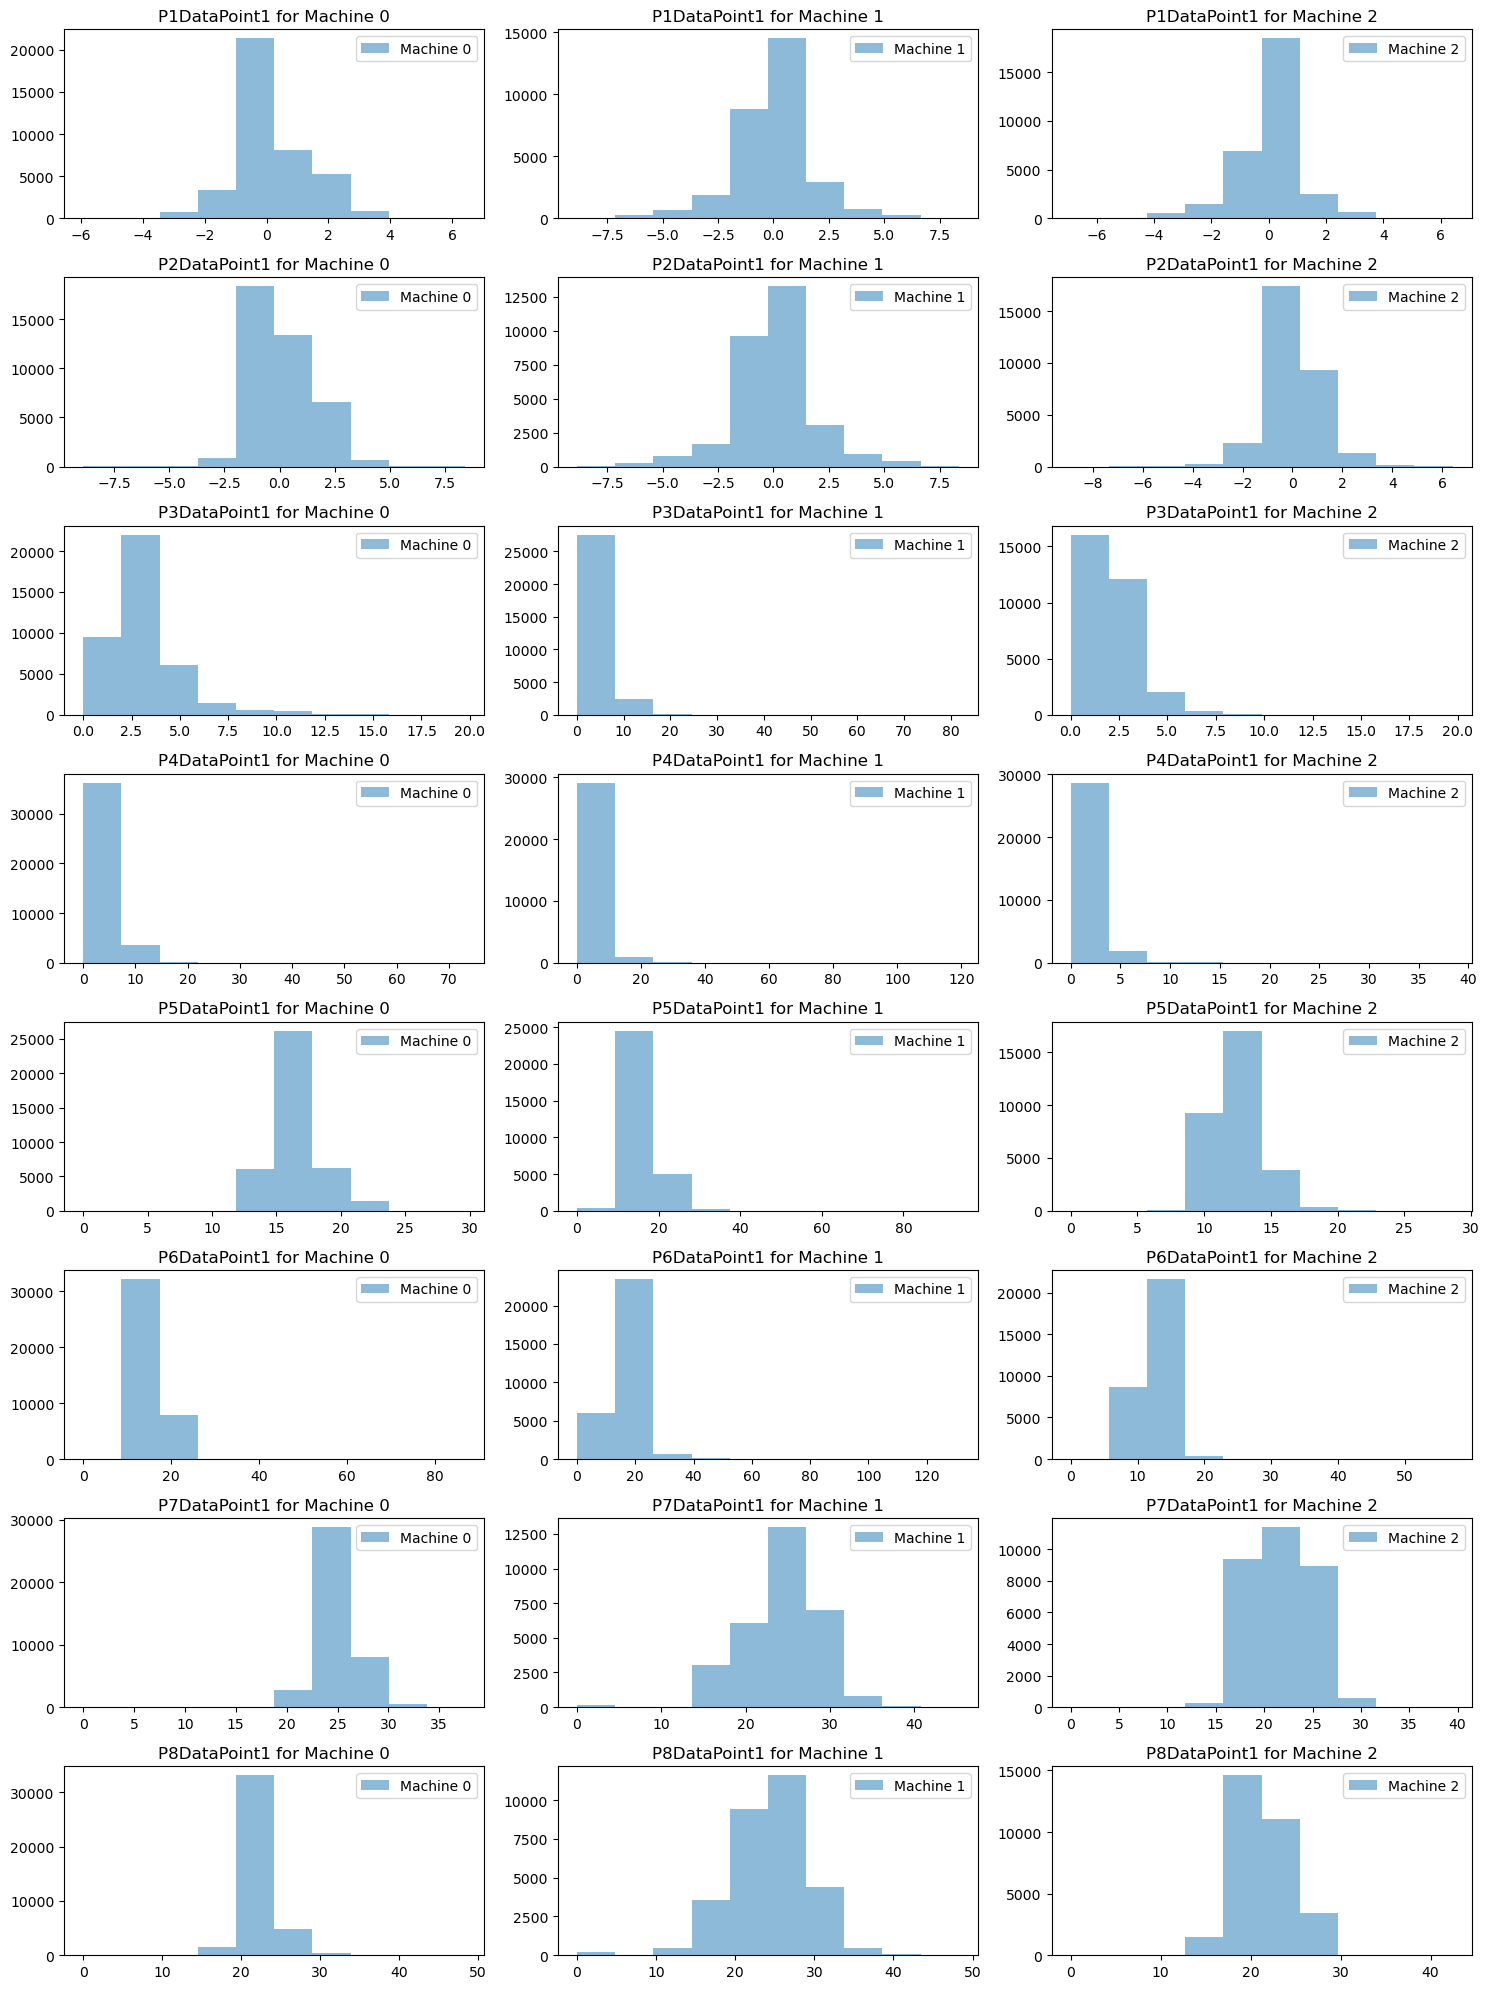

In [14]:
machines = data['Machine'].unique()[:3]  # Select the first three unique machines
features = ['P1DataPoint1', 'P2DataPoint1', 'P3DataPoint1', 'P4DataPoint1', 'P5DataPoint1', 'P6DataPoint1', 'P7DataPoint1', 'P8DataPoint1'] # These are the primary features 

fig, axs = plt.subplots(len(features), len(machines), figsize=(15, 20))

for j, feature in enumerate(features):
    for i, machine in enumerate(machines):
        axs[j, i].hist(data[data['Machine'] == machine][feature], alpha=0.5, label=f'Machine {machine}')
        axs[j, i].set_title(f'{feature} for Machine {machine}')
        axs[j, i].legend()

plt.tight_layout()
plt.show()


- The general patterns are consistent across machines, which might suggest similar operational conditions or processes affecting all machines in a comparable manner. However, slight differences in the spread and skewness could point to machine-specific behaviors or anomalies.


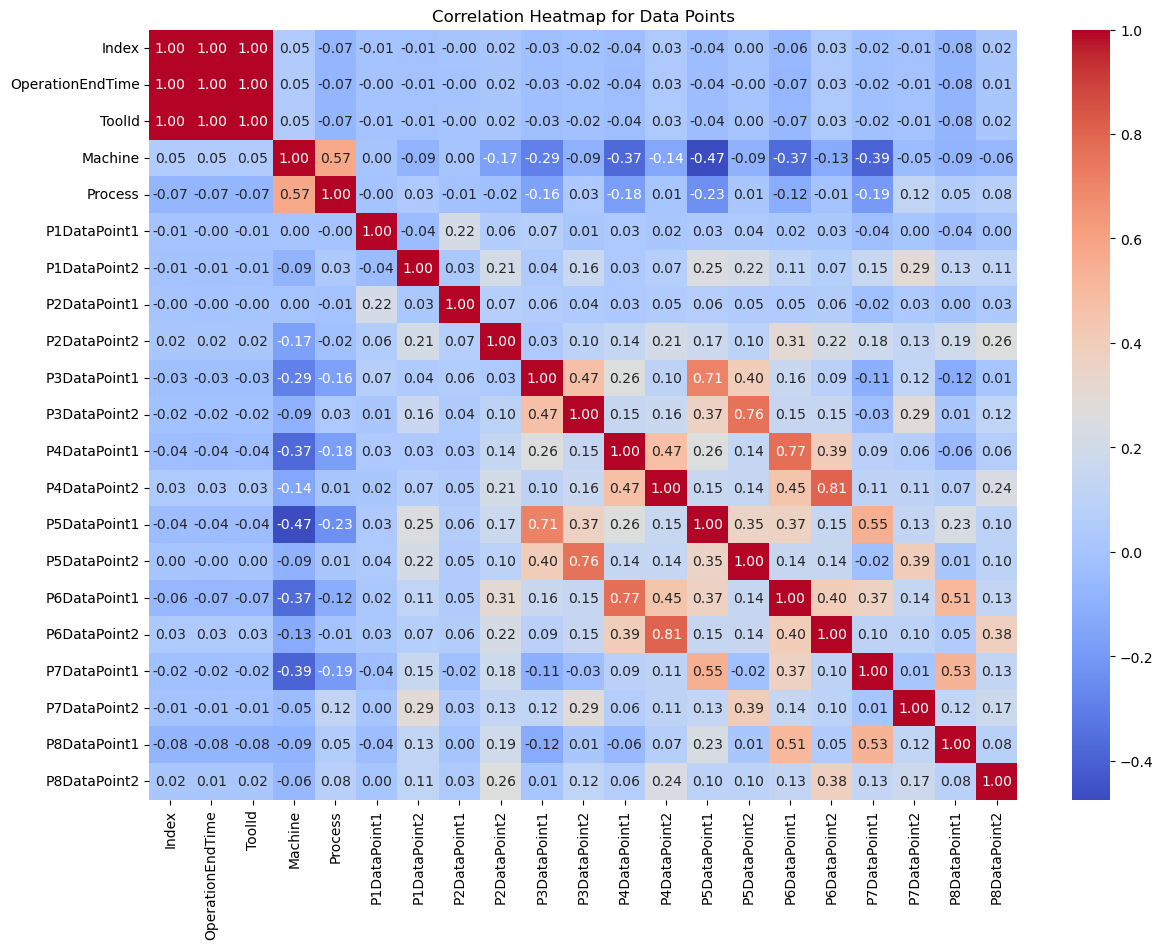

In [15]:
# Correlation Heatmap for Data Points
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Data Points')
plt.show()

1. Highly Correlated Pairs:

- P1DataPoint1 and P1DataPoint2 have a correlation close to 1, indicating that they are almost linearly related. Similarly, P2DataPoint1 and P2DataPoint2, P3DataPoint1 and P3DataPoint2, etc., show very high positive correlations. This pattern repeats for all pairs of data points with the same prefix (e.g., P4DataPoint1 and P4DataPoint2). 
- However, these points are highly correlated as for example, P2DataPoint2 is an error metric that calculates the accuracy of the primary feature which is P2DataPoint1. Hence, i would not be removing them. 

2. Moderate Correlations:

- Some data points across different prefixes also show moderate positive correlations, such as P1DataPoint1 and P2DataPoint1, indicating some degree of linear relationship between these different measures.
- Since it is not highly correlated and one feature is not affecting the other tremendously, will be keeping them. 

3. Weak or No Correlations:

- Data points like P1DataPoint1 and P5DataPoint2 show weak correlations, suggesting these features capture different aspects of the process or behavior.

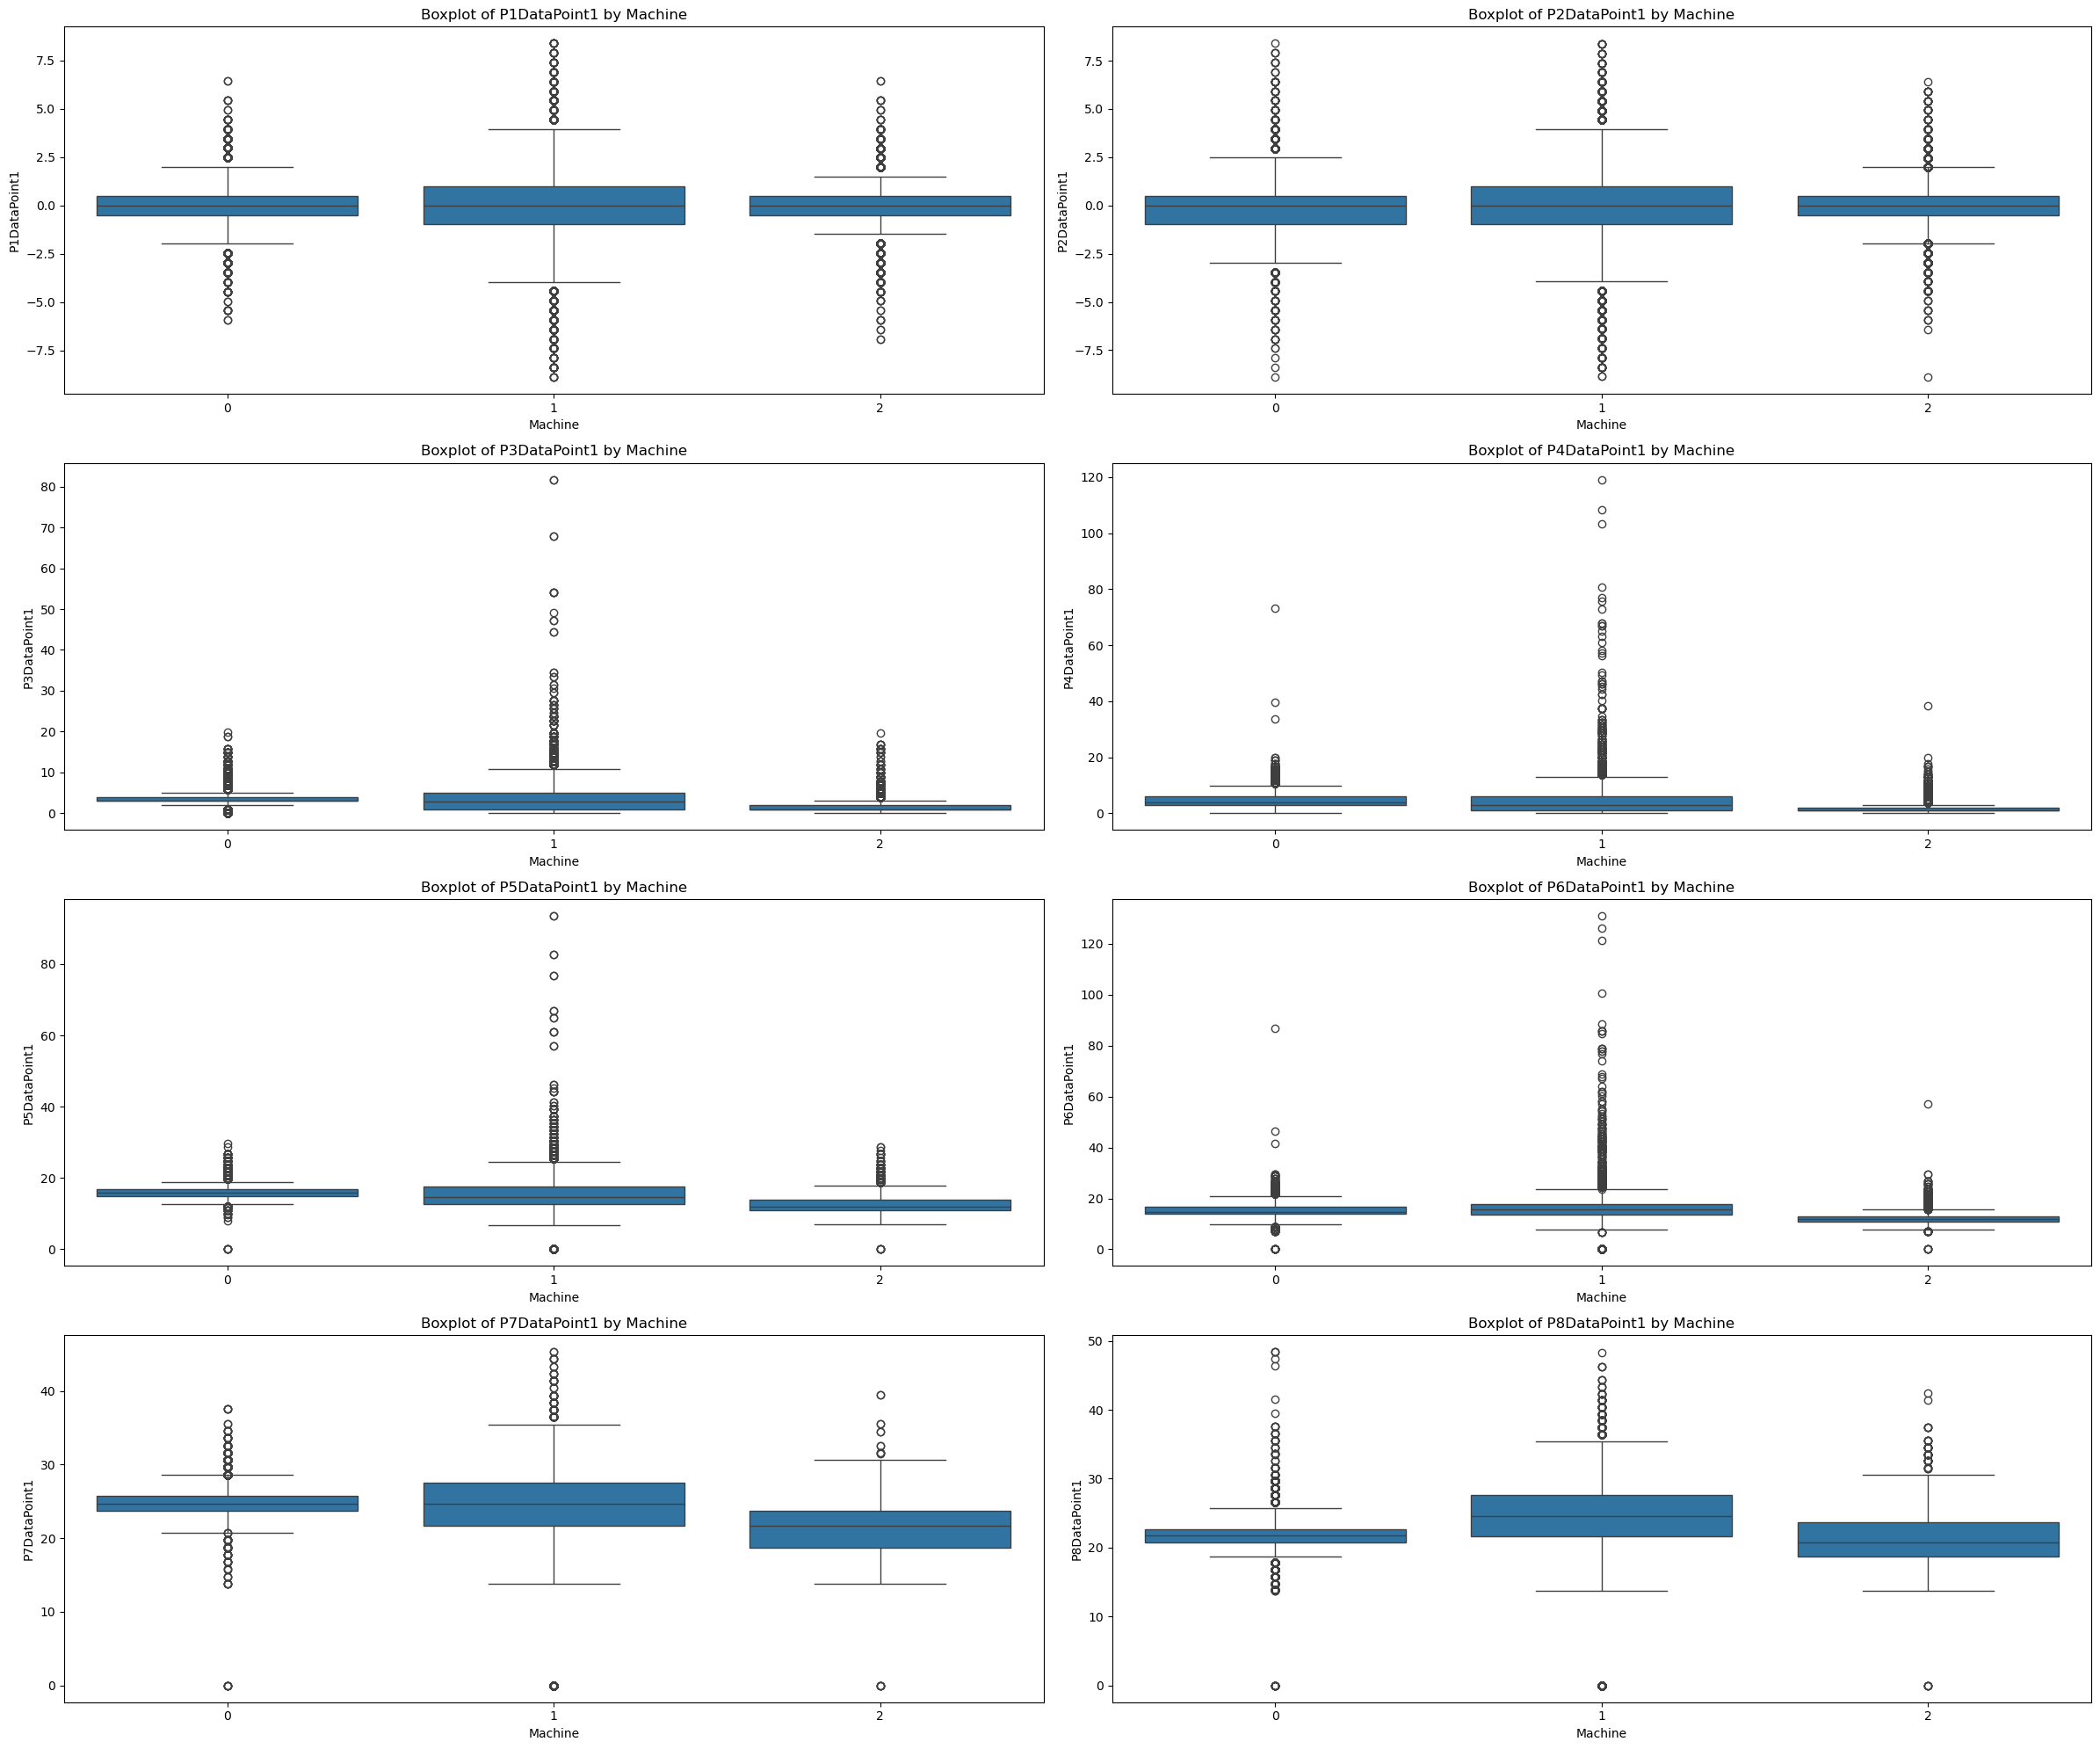

In [16]:
# Boxplots of key data points by Machine
plt.figure(figsize=(24, 20))
for i, point in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='Machine', y=point, data=data)
    plt.title(f'Boxplot of {point} by Machine')
    plt.xlabel('Machine')
    plt.ylabel(point)
plt.tight_layout()
plt.show()


1. P1DataPoint1:

- Machine 0: Shows a slightly higher median compared to Machines 1 and 2. The IQR is also larger, indicating more variability.
- Machine 1: Median is closer to the center, with a slightly smaller IQR.
- Machine 2: Median and IQR are similar to Machine 1, but with fewer outliers.

2. P2DataPoint1:

- Machine 0: Median is higher than that of Machines 1 and 2, with a moderate IQR.
- Machine 1: Median is lower with a larger IQR, indicating more variability.
- Machine 2: Similar median to Machine 1 but with fewer outliers.

3. P3DataPoint1:

- Machine 0: Lower median compared to Machines 1 and 2. The IQR is relatively small, indicating less variability.
- Machine 1: Higher median with a larger IQR.
- Machine 2: Median similar to Machine 0 but with a larger IQR.

4. P4DataPoint1:

- Machine 0: Median is higher with a small IQR, indicating consistent data.
- Machine 1: Lower median with a larger IQR.
- Machine 2: Similar median to Machine 0 but with fewer outliers.

5. P5DataPoint1:

- Machine 0: Lower median and small IQR.
- Machine 1: Higher median with a larger IQR.
- Machine 2: Median similar to Machine 1 but with fewer outliers.

6. P6DataPoint1:

- Machine 0: Higher median with a small IQR.
- Machine 1: Lower median with a larger IQR.
- Machine 2: Median similar to Machine 0 but with more outliers.

7. P7DataPoint1:

- Machine 0: Lower median with a small IQR.
- Machine 1: Higher median with a larger IQR.
- Machine 2: Median similar to Machine 0 but with more outliers.

8. P8DataPoint1:

- Machine 0: Higher median with a small IQR.
- Machine 1: Lower median with a larger IQR.
- Machine 2: Median similar to Machine 1 but with fewer outliers.

#### Summary
- Machine 0: Generally shows higher medians and smaller IQRs for most data points, indicating more consistent performance but with occasional outliers.
- Machine 1: Tends to have higher variability (larger IQRs) and more outliers, indicating less consistent performance.
- Machine 2: Exhibits behavior similar to Machine 0 for some data points and similar to Machine 1 for others, with a moderate number of outliers.

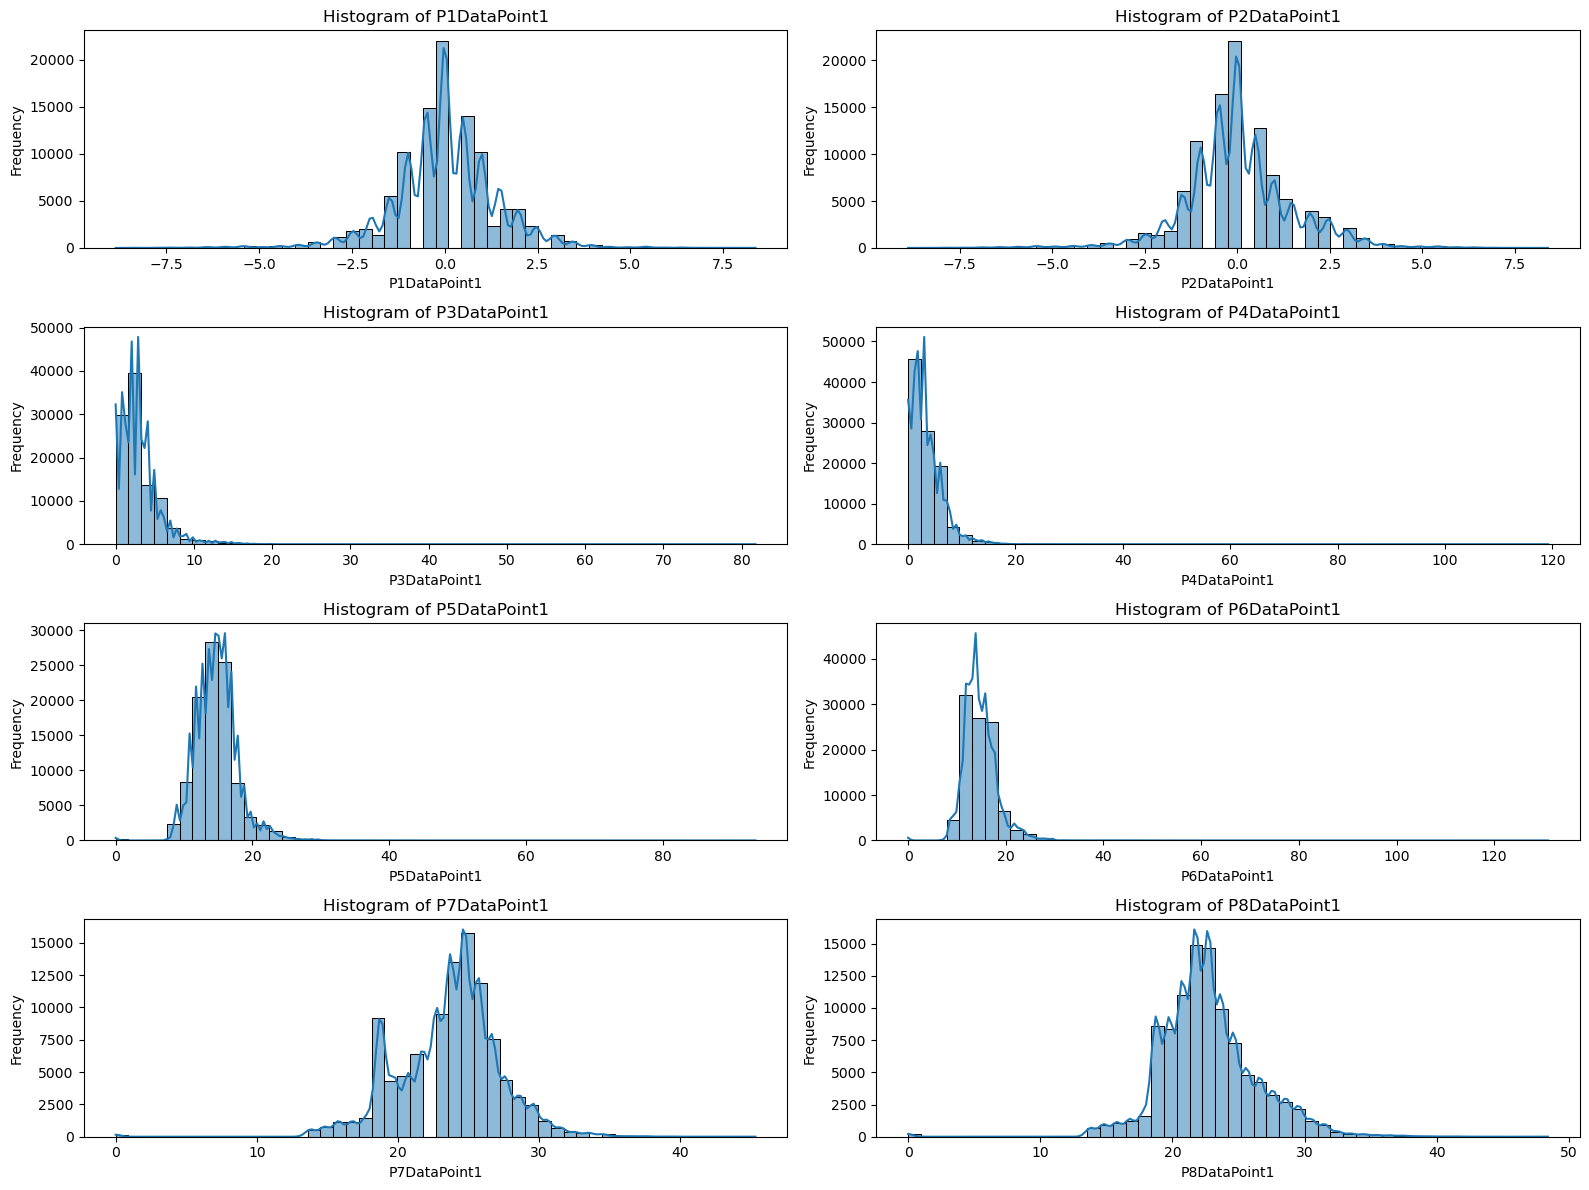

In [17]:

# Histograms of key data points
plt.figure(figsize=(16, 12))
for i, point in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[point], bins=50, kde=True)
    plt.title(f'Histogram of {point}')
    plt.xlabel(point)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### General Insights

1. Symmetrical vs. Skewed:

- P1DataPoint1 and P2DataPoint1 are symmetrical and normally distributed, suggesting consistent behavior with fewer anomalies.
- P3DataPoint1, P4DataPoint1, P5DataPoint1, and P6DataPoint1 are positively skewed, indicating most data points are low, but there are significant high-value outliers.

2. Bimodal Distributions:

- P7DataPoint1 and P8DataPoint1 exhibit bimodal distributions, indicating the presence of two distinct subgroups. This could imply different operating modes or conditions within the data.

3. Outliers:

- Several features have notable outliers, especially P3DataPoint1, P4DataPoint1, P5DataPoint1, and P6DataPoint1. These outliers could be indicative of rare but significant events or anomalies that should be investigated further.

#### Possible Suggestions
- The skewed distributions of P3DataPoint1 to P6DataPoint1 indicate that transformations (e.g., log transformation) might be needed before applying certain models.
- Features with significant outliers might need outlier detection and treatment before training anomaly detection models to improve model robustness and accuracy.
- Skewed features may benefit from normalization techniques to reduce skewness and improve the performance of machine learning models.

In [18]:

# Count of unique values in Machine column
machine_counts = data['Machine'].value_counts()

# Function to create a donut chart
def create_donut_chart(values, labels, title):
    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    # Draw a circle at the center to turn the pie into a donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.title(title)
    plt.tight_layout()
    plt.show()

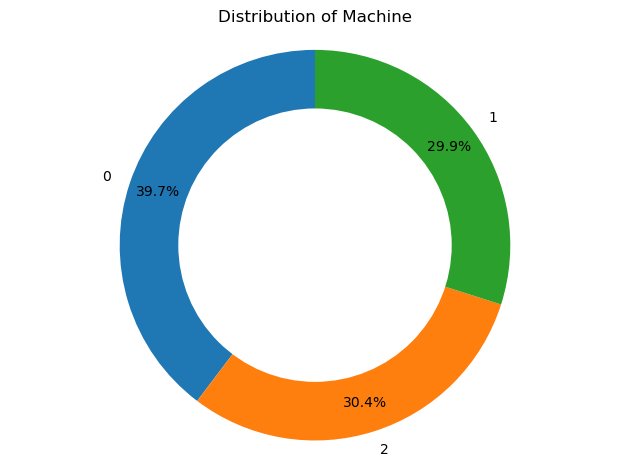

In [19]:
# Create donut chart for Machine column
create_donut_chart(machine_counts.values, machine_counts.index, 'Distribution of Machine')

In [20]:
# Function to identify outliers using IQR and return bounds as well
def identify_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound



# Identify outliers for each feature
outliers_dict = {}
for feature in features:
    outliers_dict[feature], _, _ = identify_outliers(data, feature)
    print(f"Feature: {feature}")
    print(outliers_dict[feature][[feature]])

# Count of outliers in each feature
outlier_counts = {feature: len(outliers) for feature, outliers in outliers_dict.items()}
print("Count of outliers in each feature:")
print(outlier_counts)

Feature: P1DataPoint1
        P1DataPoint1
5             -3.940
6              3.940
10             3.454
13             3.454
55            -2.955
...              ...
100350         3.458
100457        -2.955
100460        -2.955
100563         3.458
100876         3.458

[4442 rows x 1 columns]
Feature: P2DataPoint1
        P2DataPoint1
1             -4.432
6              3.447
9              2.462
12             2.964
21             4.935
...              ...
100843         2.964
100855         2.470
100860        -3.458
100861         3.458
100876         2.470

[12078 rows x 1 columns]
Feature: P3DataPoint1
        P3DataPoint1
76             9.880
148            8.865
150           15.760
170           11.820
178           12.805
...              ...
99849         10.835
99921          8.865
100073         8.865
100086         8.865
100113         8.865

[3700 rows x 1 columns]
Feature: P4DataPoint1
        P4DataPoint1
5             10.835
55            13.790
89            13.

In [21]:
# There is a total of 35,952 outliers in the dataset

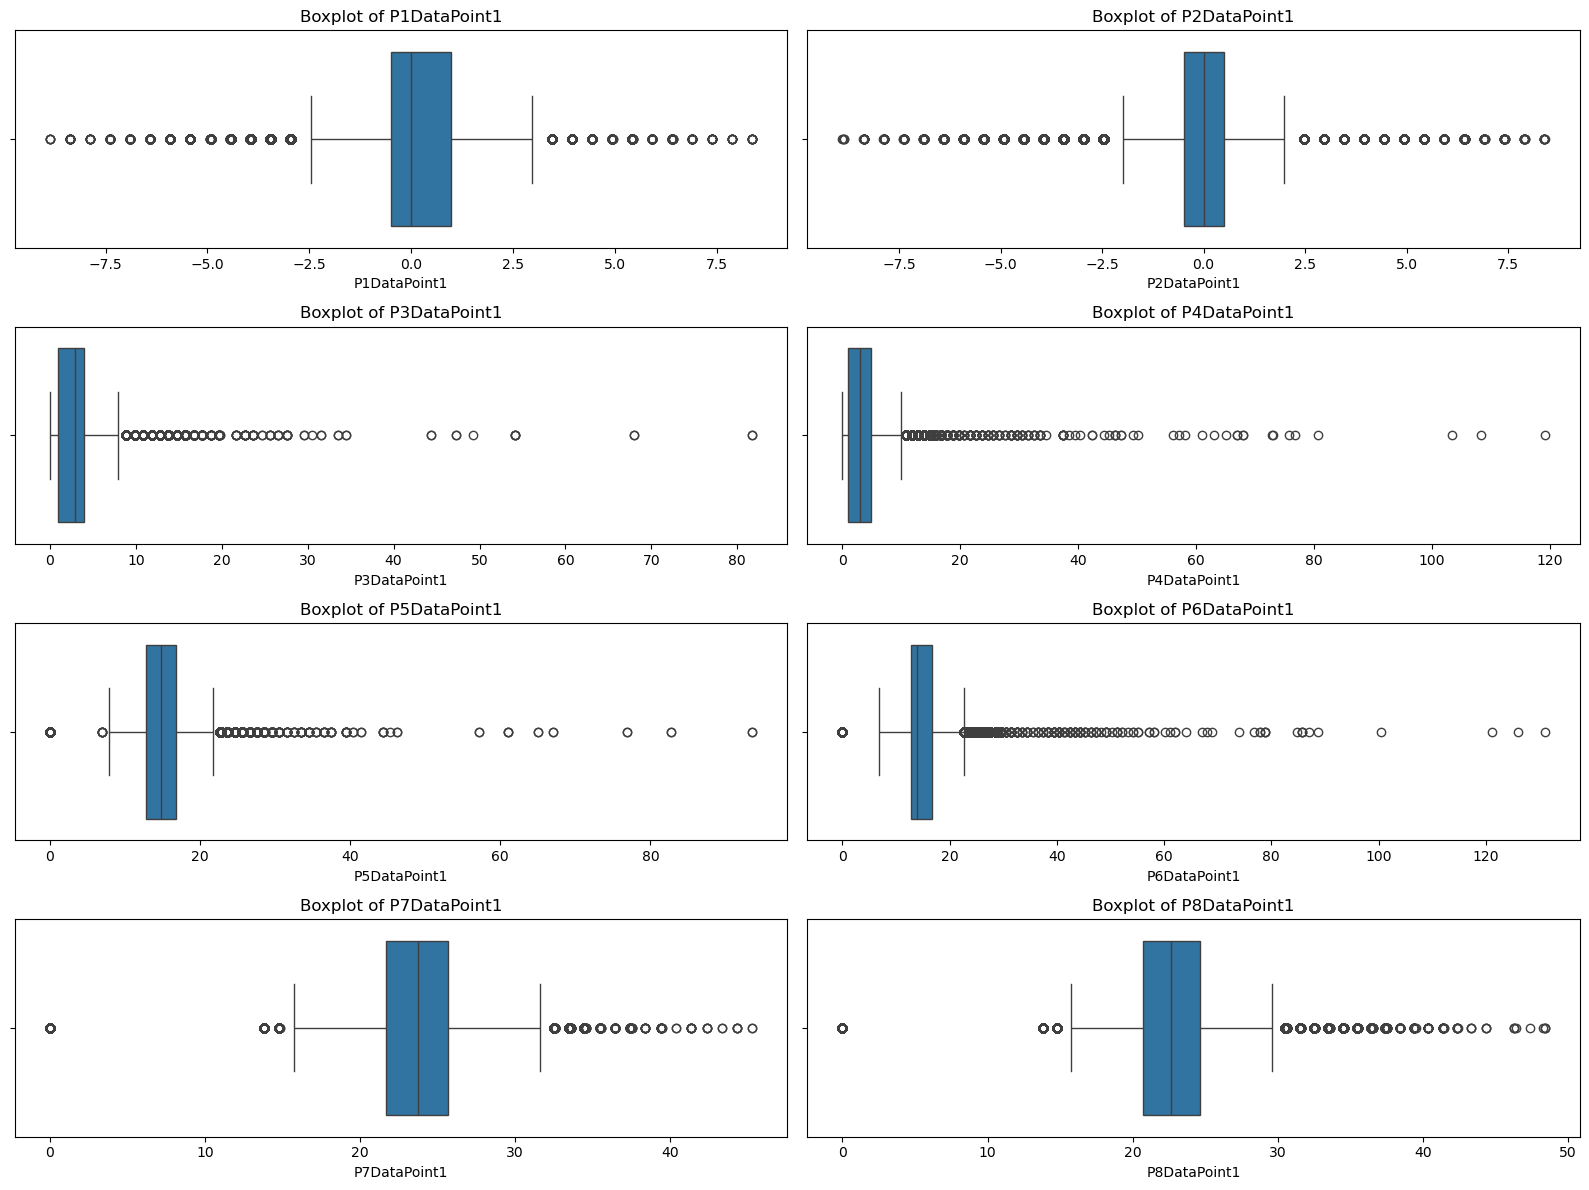

In [22]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

- Every outlier that is present in the dataset is an anomaly. Hence, would not be removing or capping these outliers as they are crucial for anomaly detection. 

- PCA and t-SNE are sensitive to outliers. Removing extreme values could improve the quality of the dimensionality reduction, leading to better separation of points in your visualizations. 

### Data Pre-Processing

In [23]:
# 1. Remove extreme outliers


# Function to remove outliers using IQR
def remove_outliers(df, feature):
    _, lower_bound, upper_bound = identify_outliers(df, feature)
    df_cleaned = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df_cleaned
print("Original data shape:", data.shape)

Original data shape: (100858, 21)


In [24]:
# Create a copy of the data for cleaning
data_cleaned = data.copy()

# Identify and remove outliers for each feature
outliers_dict = {}
for feature in features:
    outliers_dict[feature], _, _ = identify_outliers(data_cleaned, feature)
    data_cleaned = remove_outliers(data_cleaned, feature)
    print(f"Removed outliers for feature: {feature}")
    
# Display the shape after removing outliers
print("Data shape after removing outliers:", data_cleaned.shape)

Removed outliers for feature: P1DataPoint1
Removed outliers for feature: P2DataPoint1
Removed outliers for feature: P3DataPoint1
Removed outliers for feature: P4DataPoint1
Removed outliers for feature: P5DataPoint1
Removed outliers for feature: P6DataPoint1
Removed outliers for feature: P7DataPoint1
Removed outliers for feature: P8DataPoint1
Data shape after removing outliers: (70950, 21)


In [25]:
df = data_cleaned.drop(['P1DataPoint2', 'P2DataPoint2', 'P3DataPoint2', 'P4DataPoint2', 'P5DataPoint2', 'P6DataPoint2', 'P7DataPoint2', 'P8DataPoint2'], axis=1)

In [26]:
# 2. Scaling
   
features_scaled = StandardScaler().fit_transform(df) # standardizes the features of df by removing the mean and scaling to unit variance 
X1 = pd.DataFrame(features_scaled)
X1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.772461,-1.632732,-1.740549,-1.052936,-0.811402,-2.409576,-1.017737,-0.352417,2.504094,1.155391,1.390557,0.848552,-0.572115
1,-1.772427,-1.632724,-1.736884,1.162736,0.985775,0.485515,-2.115926,0.219679,0.545740,0.723542,1.382842,0.839747,0.246967
2,-1.772392,-1.632692,-1.740549,-1.052936,-0.811402,1.451848,-0.467529,0.795259,1.036814,1.155391,0.493830,0.179333,-0.157751
3,-1.772289,-1.632652,-1.740549,-1.052936,-0.811402,0.969170,0.082679,0.221421,0.058627,0.305457,-0.402897,-0.155276,-0.572115
4,-1.772255,-1.632621,-1.740549,-1.052936,-0.811402,-2.409576,0.632887,0.221421,1.036814,0.730424,0.045466,0.179333,-0.986480


### Modelling

In [27]:
# 1. DBSCAN

In [28]:
# Apply DBSCAN
# need to adjust eps and min_samples 
dbscan = DBSCAN(eps=2.0, min_samples=61) 
dbscan.fit(X1)

DBSCAN(eps=2.0, min_samples=61)

In [29]:
# Create a copy of the original dataframe
DBSCAN_df = X1.copy()

# Add cluster labels to the copy
DBSCAN_df['cluster'] = dbscan.labels_

In [30]:
# Count the number of clusters and noise points
num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
num_noise = list(dbscan.labels_).count(-1)

print(f'Number of clusters found: {num_clusters}')
print(f'Number of noise points: {num_noise}')

Number of clusters found: 1
Number of noise points: 1759


In [31]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
principal_components_before = pca.fit_transform(features_scaled)

DBSCAN_df['pca_one'] = principal_components_before[:, 0]
DBSCAN_df['pca_two'] = principal_components_before[:, 1]


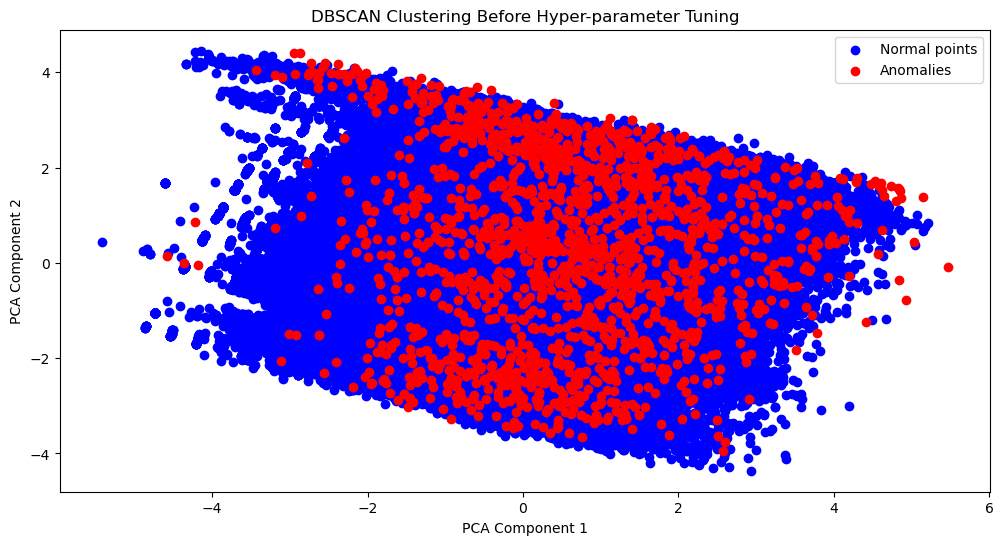

In [32]:
# Plot the results before hyper-parameter tuning
plt.figure(figsize=(12, 6))

# Normal points
plt.scatter(DBSCAN_df[DBSCAN_df['cluster'] != -1]['pca_one'],
            DBSCAN_df[DBSCAN_df['cluster'] != -1]['pca_two'],
            c='blue', label='Normal points')

# Anomalies
plt.scatter(DBSCAN_df[DBSCAN_df['cluster'] == -1]['pca_one'],
            DBSCAN_df[DBSCAN_df['cluster'] == -1]['pca_two'],
            c='red', label='Anomalies')

plt.title('DBSCAN Clustering Before Hyper-parameter Tuning')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()



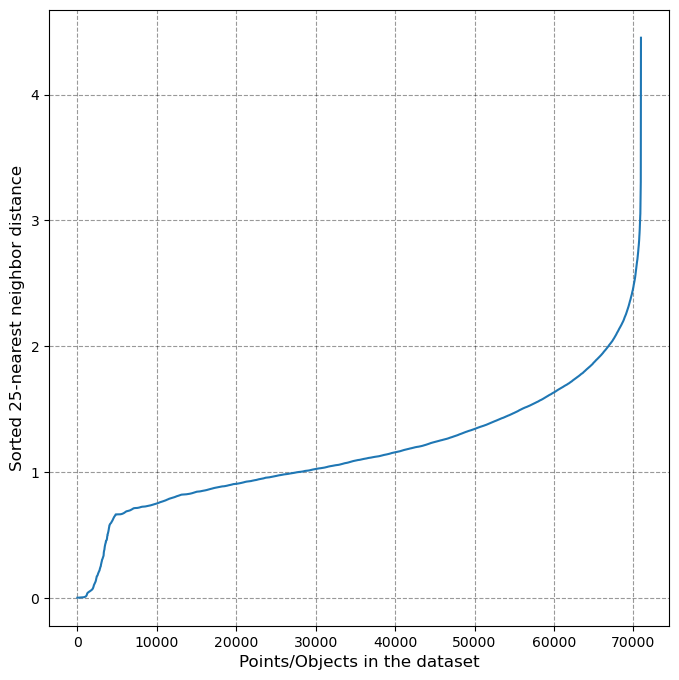

In [33]:
# Purpose: Hyper-Parameter tuning, Selecting the best value for eps using k-nearest neighbours approach
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * features_scaled.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=features_scaled, k=k)

# Find the elbow point manually from the graph and set eps accordingly

1. The purpose of this code is to help select the optimal eps value for the DBSCAN clustering algorithm.

2. What it does:

- It calculates the distance of each data point to its k-th nearest neighbor.
- Then, it sorts these distances and plots them.
- The plot helps to identify an "elbow point," which indicates the appropriate eps value. This eps value is crucial for defining the neighborhood size used in DBSCAN to determine clusters

In [34]:
# Retrain DBSCAN with new parameters
dbscan_tuned = DBSCAN(eps=2.1, min_samples=29)
dbscan_tuned.fit(X1)

DBSCAN(eps=2.1, min_samples=29)

In [35]:
# Create a copy of the original dataframe
DBSCAN_df_tuned = X1.copy()

In [36]:
# Add the new cluster labels to the copy
DBSCAN_df_tuned['cluster'] = dbscan_tuned.labels_

In [37]:
# Count the number of clusters and noise points after tuning
num_clusters_tuned = len(set(dbscan_tuned.labels_)) - (1 if -1 in dbscan_tuned.labels_ else 0)
num_noise_tuned = list(dbscan_tuned.labels_).count(-1)

print(f'Number of clusters found after tuning: {num_clusters_tuned}')
print(f'Number of noise points after tuning: {num_noise_tuned}')

Number of clusters found after tuning: 1
Number of noise points after tuning: 659


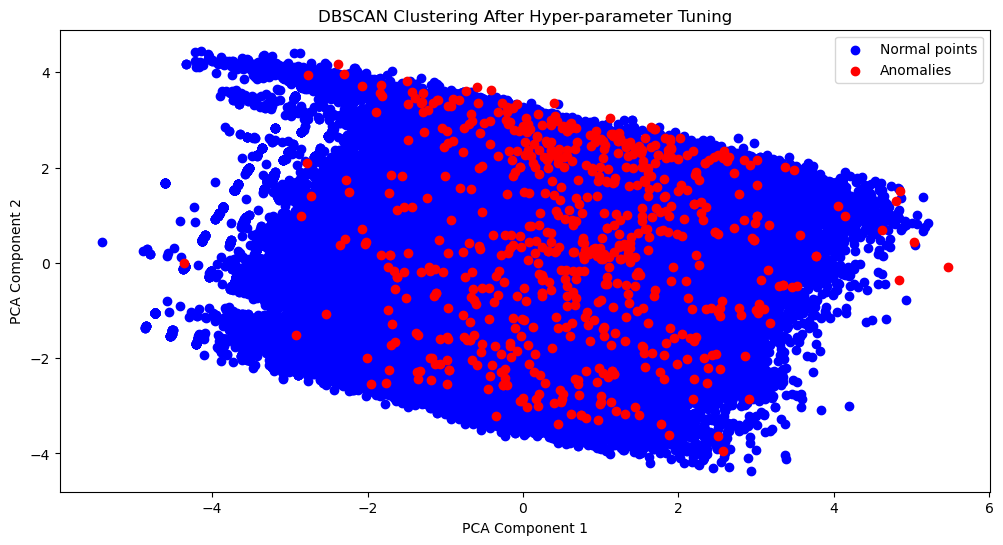

In [38]:
# Apply PCA to reduce to 2 principal components
pca_tuned = PCA(n_components=2)
principal_components_after = pca_tuned.fit_transform(features_scaled)

DBSCAN_df_tuned['pca_one'] = principal_components_after[:, 0]
DBSCAN_df_tuned['pca_two'] = principal_components_after[:, 1]

# Plot the results after hyper-parameter tuning
plt.figure(figsize=(12, 6))

# Normal points
plt.scatter(DBSCAN_df_tuned[DBSCAN_df_tuned['cluster'] != -1]['pca_one'],
            DBSCAN_df_tuned[DBSCAN_df_tuned['cluster'] != -1]['pca_two'],
            c='blue', label='Normal points')

# Anomalies
plt.scatter(DBSCAN_df_tuned[DBSCAN_df_tuned['cluster'] == -1]['pca_one'],
            DBSCAN_df_tuned[DBSCAN_df_tuned['cluster'] == -1]['pca_two'],
            c='red', label='Anomalies')

plt.title('DBSCAN Clustering After Hyper-parameter Tuning')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

#### Based on the PCA visualizations of the DBSCAN model before and after hyperparameter tuning, here’s an analysis of how the model's performance has changed:

1. Increased Compactness and Separation:

- Before Tuning: The data points, both normal and anomalous, appear more spread out across the PCA components, with significant overlap between the two categories. This suggests that the DBSCAN model was not as effective in clustering the normal points together, nor in separating anomalies from normal points.
- After Tuning: The normal points (blue) are more tightly clustered, indicating that the DBSCAN model has improved in grouping similar points together. The anomalies (red) are more distinctly separated, suggesting better identification of outliers.

2. Reduced Overlap:

- Before Tuning: There is considerable overlap between the normal points and anomalies, which indicates that the DBSCAN model was not clearly distinguishing between the two. This overlap could have resulted in a higher rate of misclassification.
- After Tuning: The overlap between the normal points and anomalies has decreased. This reduction indicates that the DBSCAN model is now more effective in distinguishing normal points from anomalies, likely leading to more accurate anomaly detection.

3. Improved Cluster Definition:

- Before Tuning: The clusters formed by the normal points were not well-defined, and anomalies were scattered throughout the PCA space. This suggests that the clustering structure was not as clear, leading to potential misidentification of anomalies.
- After Tuning: The clusters of normal points have become more defined, with a clearer boundary separating them from the anomalies. This indicates that the DBSCAN model is now better at identifying dense regions of normal data and distinguishing them from outliers.

4. Outlier Identification:

- Before Tuning: Anomalies were distributed more randomly, with many anomalies close to or within the clusters of normal points. This suggests that the DBSCAN model was less sensitive to detecting true outliers.
- After Tuning: Anomalies are more consistently located outside the main clusters, indicating that the DBSCAN model has improved in isolating true outliers and reducing false positives within the normal clusters.

#### Reasons as to why the model is not performing at its best: (Assumptions and Justification)

1. High-Dimensional Data Complexity
- In my case, PCA is being used to reduce the dimensionality of my data to visualize the clustering results from DBSCAN. However, PCA is a linear technique, and my original data likely has complex, nonlinear relationships. When these complex relationships are projected into a lower-dimensional space (like 2D), it might oversimplify the data structure. This can result in a spread and overlap of points that don't fully represent the actual separations that exist in the original high-dimensional space. This could explain why, even after tuning, the clusters are not clearly separated.

2. DBSCAN Limitations in High-Dimensional Spaces
- DBSCAN is a density-based clustering method, which works well in low-dimensional spaces where clusters are clearly defined by regions of high point density. However, in high-dimensional spaces, the concept of density becomes less clear, as distances between points tend to become more uniform. As a result, DBSCAN might struggle to differentiate between clusters, leading to poor clustering performance. The PCA plots that i've displayed suggests that the data points might not be forming dense clusters in the high-dimensional space, leading DBSCAN to misclassify many points as anomalies or to fail in identifying clusters altogether.

3. Uniform Point Density
- From the PCA plots, it appears that the data points are spread out rather uniformly without clear, dense clusters. This uniformity suggests that the data points might have similar densities, making it difficult for DBSCAN to identify distinct clusters. In DBSCAN, clusters are defined by regions of higher density separated by regions of lower density, so if the data doesn't naturally exhibit this kind of density variation, DBSCAN might not perform well.

- DBSCAN in general is not suitable for processing large datasets. 

In [ ]:
# 2. Isolation Forest

In [40]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01),\
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0) # initializes the model with the parameters
clf.fit(X1) # fit the model to the numerical data

IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [41]:
# Get the predictions (-1 for anomalies, 1 for normal points)
labels = clf.predict(X1)

In [42]:
# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X1)

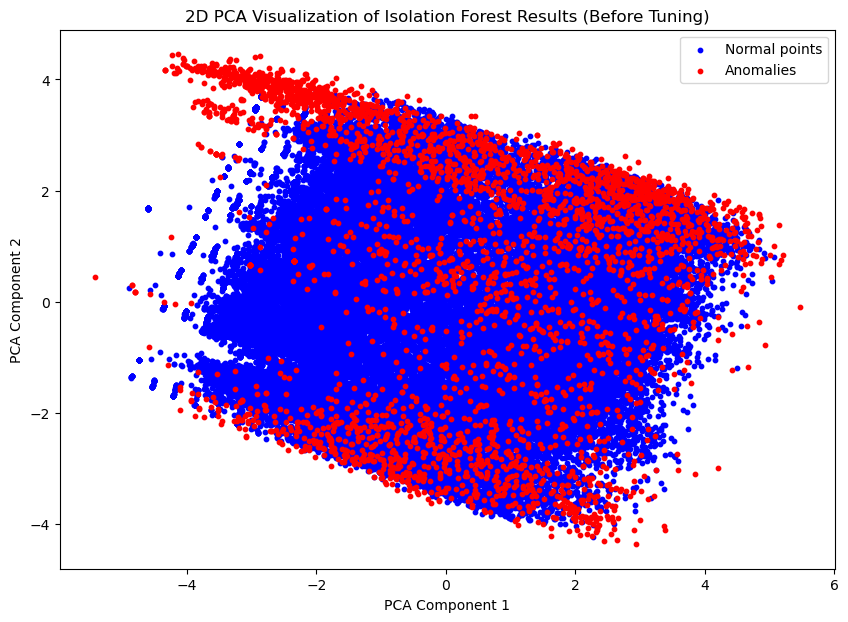

In [58]:
# Visualize PCA results before tuning
plt.figure(figsize=(10, 7))
plt.scatter(pca_result_best[labels_best == 1, 0], pca_result_best[labels_best == 1, 1], 
            c='blue', label='Normal points', s=10)
plt.scatter(pca_result_best[labels_best == -1, 0], pca_result_best[labels_best == -1, 1], 
            c='red', label='Anomalies', s=10)
plt.title('2D PCA Visualization of Isolation Forest Results (Before Tuning)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()



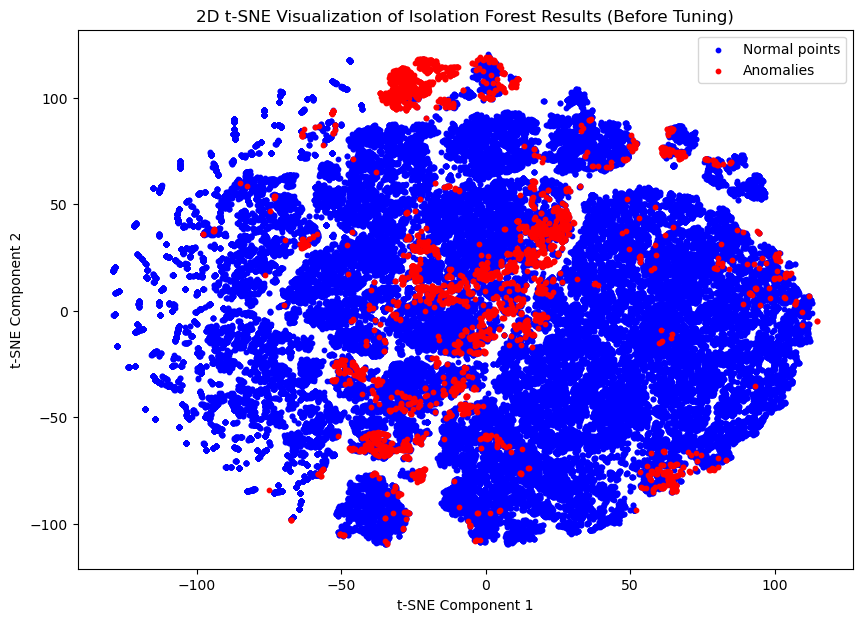

In [59]:
# Apply t-SNE
tsne_result_best = tsne.fit_transform(X1)

# Visualize t-SNE results before tuning
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result_best[labels_best == 1, 0], tsne_result_best[labels_best == 1, 1], 
            c='blue', label='Normal points', s=10)
plt.scatter(tsne_result_best[labels_best == -1, 0], tsne_result_best[labels_best == -1, 1], 
            c='red', label='Anomalies', s=10)
plt.title('2D t-SNE Visualization of Isolation Forest Results (Before Tuning)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [45]:
# Step 2a: Tune the number of estimators (n_estimators)
best_n_estimators = 100  # Starting value
best_score = float('inf')  # Assuming lower contamination score is better

for n_estimators in [50, 100, 150, 200]:
    clf = IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=0.01, 
                          max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
    clf.fit(X1)
    score = clf.decision_function(X1).mean()  # Average anomaly score
    if score < best_score:
        best_score = score
        best_n_estimators = n_estimators

# Step 2b: Tune the contamination parameter based on best n_estimators
best_contamination = 0.01  # Starting value

for contamination in [0.01, 0.02, 0.05]:
    clf = IsolationForest(n_estimators=best_n_estimators, max_samples='auto', contamination=contamination, 
                          max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
    clf.fit(X1)
    score = clf.decision_function(X1).mean()
    if score < best_score:
        best_score = score
        best_contamination = contamination

# Step 2c: Tune max_samples based on best n_estimators and best_contamination
best_max_samples = 'auto'  # Starting value

for max_samples in ['auto', 0.5, 0.75, 1.0]:
    clf = IsolationForest(n_estimators=best_n_estimators, max_samples=max_samples, contamination=best_contamination, 
                          max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
    clf.fit(X1)
    score = clf.decision_function(X1).mean()
    if score < best_score:
        best_score = score
        best_max_samples = max_samples

# Best parameters after tuning
print("Best Parameters found:", {'n_estimators': best_n_estimators, 
                                 'contamination': best_contamination, 
                                 'max_samples': best_max_samples})


Best Parameters found: {'n_estimators': 100, 'contamination': 0.05, 'max_samples': 'auto'}


In [ ]:
# Retrain the model with the selected best parameters
clf_best = IsolationForest(n_estimators=best_n_estimators, max_samples=best_max_samples, 
                           contamination=best_contamination, max_features=1.0, 
                           bootstrap=False, n_jobs=-1, random_state=42)
clf_best.fit(X1)

# Get predictions with the tuned model
labels_best = clf_best.predict(X1)

# Apply PCA
pca_result_best = pca.fit_transform(X1)

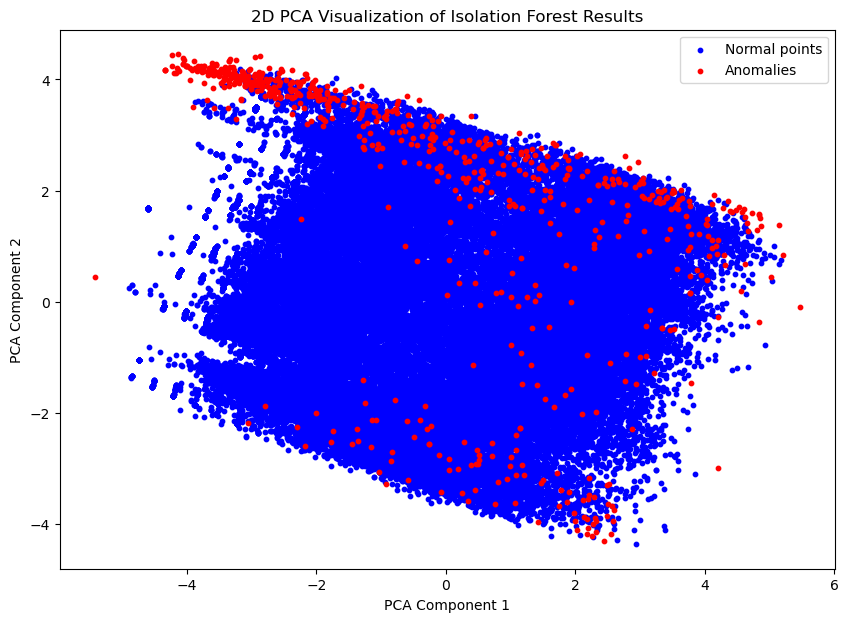

In [43]:
# Plotting the 2D PCA results
plt.figure(figsize=(10, 7))

# Plot normal points
plt.scatter(pca_result[labels == 1, 0], pca_result[labels == 1, 1], 
            c='blue', label='Normal points', s=10)

# Plot anomalies
plt.scatter(pca_result[labels == -1, 0], pca_result[labels == -1, 1], 
            c='red', label='Anomalies', s=10)

plt.title('2D PCA Visualization of Isolation Forest Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

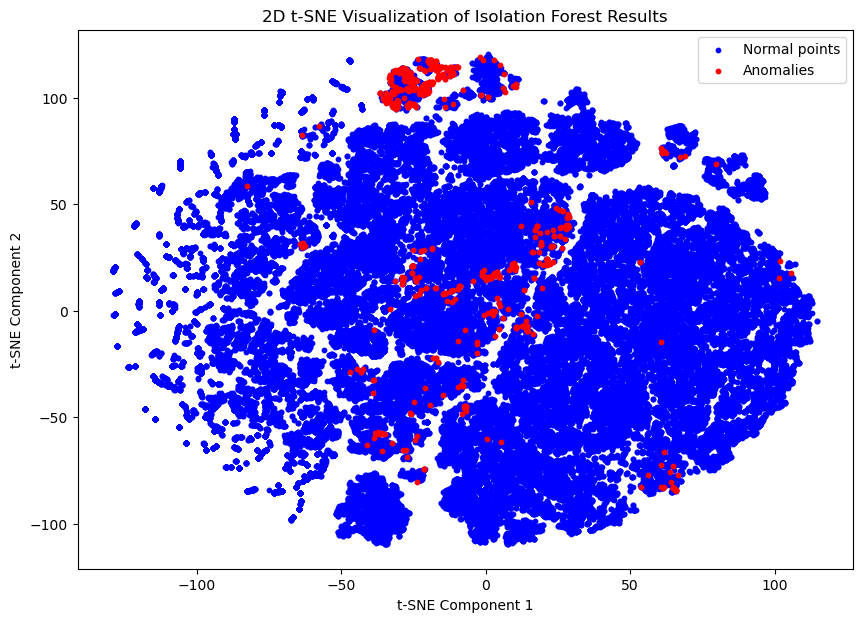

In [44]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the data to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X1)

# Plotting the 2D t-SNE results
plt.figure(figsize=(10, 7))

# Plot normal points
plt.scatter(tsne_result[labels == 1, 0], tsne_result[labels == 1, 1], 
            c='blue', label='Normal points', s=10)

# Plot anomalies
plt.scatter(tsne_result[labels == -1, 0], tsne_result[labels == -1, 1], 
            c='red', label='Anomalies', s=10)

plt.title('2D t-SNE Visualization of Isolation Forest Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


#### Analyze model performance in terms of PCA:

##### Before tuning:
1. Spread of Anomalies: In the initial PCA plot, anomalies (red points) are scattered quite broadly across the space. Some of them overlap significantly with the normal points (blue points), which suggests that the model may not have been distinguishing anomalies from normal points effectively.

2. Clustering of Normal Points: The normal points seem to be spread out across the entire plot, with a few distinct clusters but without a very clear separation from the anomalies.

##### After tuning:
1. Concentration of Anomalies: After hyperparameter tuning, the anomalies appear to be more concentrated in certain areas of the PCA plot. There is a noticeable reduction in the overlap between anomalies and normal points, which indicates that the model is better at isolating the outliers.

2. Clearer Separation: The separation between the normal and anomalous points is more pronounced. The normal points (blue) are more tightly clustered, and the anomalies (red) are located more distinctly, suggesting that the model has become more accurate in detecting anomalies.

#### While the model has shown improvement after hyperparameter tuning, there are a few reasons why it might not be performing at its best. Here are some possible explanations and assumptions:

1. High Dimensionality of the Data:
- Explanation: High-dimensional data can pose challenges for anomaly detection algorithms like Isolation Forest. In high-dimensional spaces, the distance between points can become less meaningful, and the concept of "nearest neighbors" can break down, making it harder to distinguish anomalies from normal points.

- Assumption: Even after dimensionality reduction using PCA, important features may have been lost, causing the model to struggle in correctly identifying outliers. PCA focuses on capturing the maximum variance, which might not always align with the most critical features for anomaly detection.


2. Complexity of the Data:

- Explanation: The underlying structure of the data might be too complex or non-linear for the Isolation Forest model to capture effectively, even after tuning.

- Assumption: The data might contain interactions between features or non-linear relationships that are not easily captured by a tree-based model. As a result, the model might misclassify some normal points as anomalies or fail to detect all the true anomalies.

3. Suboptimal Hyperparameter Choices:

- Explanation: While i did performed hyperparameter tuning, it's possible that the chosen parameters, although better, are still not optimal.

- Assumption: The manual or greedy tuning process might have settled on a local minimum rather than the global best set of hyperparameters. A more exhaustive search could potentially find better parameter settings, though this would increase computational cost.

4. Distribution of Anomalies:

- Explanation: The distribution of anomalies within the dataset might be such that they are not easily separable from normal points.

- Assumption: If the anomalies are not significantly different from normal points or are very sparse and mixed in with normal data, the model might struggle to detect them effectively. This is particularly challenging when anomalies lie close to the decision boundary.

In [ ]:
# 3. Autoencoder

In [48]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(X1, test_size=0.2, random_state=42)


In [49]:
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14  # You can adjust this value

In [50]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [51]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [52]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4971 - val_loss: 0.1416
Epoch 2/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1109 - val_loss: 0.0715
Epoch 3/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0692 - val_loss: 0.0658
Epoch 4/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0642 - val_loss: 0.0635
Epoch 5/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0629 - val_loss: 0.0620
Epoch 6/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0616 - val_loss: 0.0614
Epoch 7/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0612 - val_loss: 0.0608
Epoch 8/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0605 - val_loss: 0.0608
Epoch 9/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0605 - val_loss: 0.0607
Epoch 10/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0598 - val_loss: 0.0603
Epoch 11/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0591 - val_loss: 0.0602
Epoch 12/50
1774/1774 ━━━━━━━

In [53]:
# Get reconstruction error on the test set
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=1)

444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [54]:
# Define an anomaly threshold
threshold = np.percentile(mse, 95)
print(f"Anomaly threshold: {threshold}")

Anomaly threshold: 0.19372434529440455


In [55]:
# Identify anomalies
anomalies = mse > threshold
print(f"Number of anomalies: {np.sum(anomalies)}")

Number of anomalies: 710


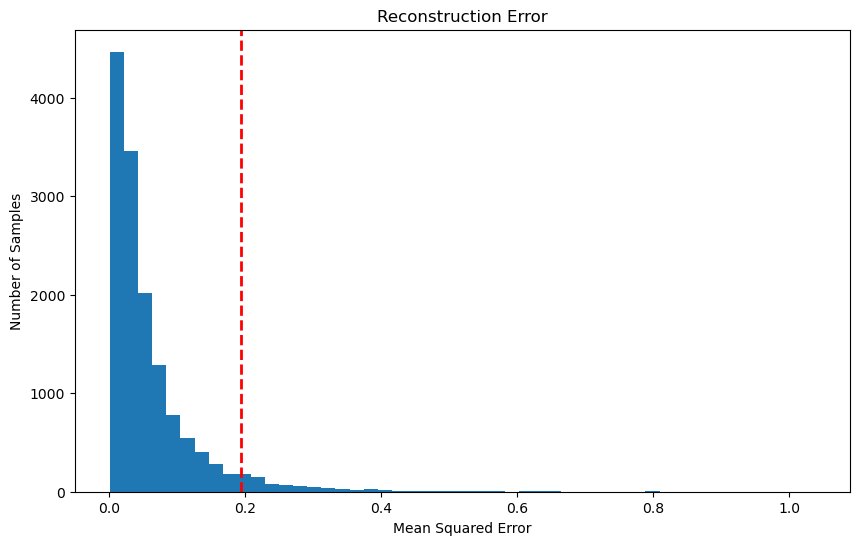

In [56]:
# Visualize the reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title('Reconstruction Error')
plt.xlabel('Mean Squared Error')
plt.ylabel('Number of Samples')
plt.show()


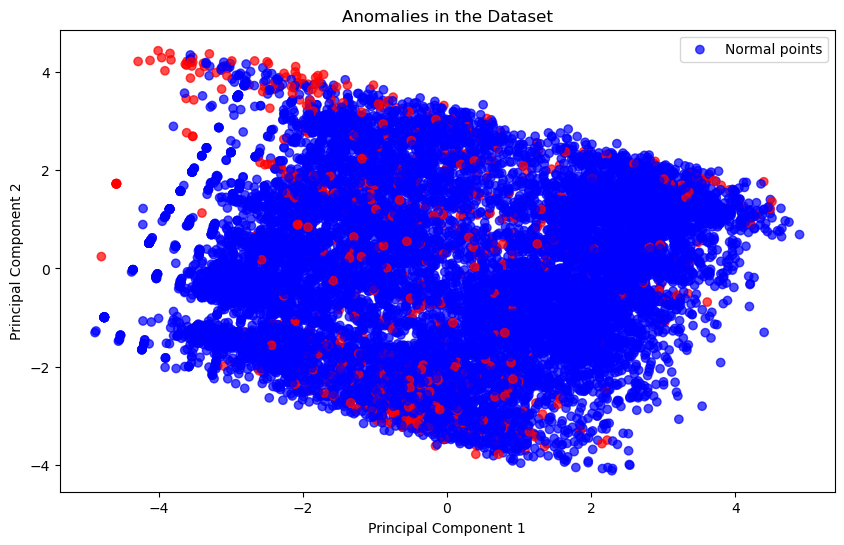

In [57]:
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Visualize the anomalies and normal points
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=['red' if x else 'blue' for x in anomalies], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Anomalies in the Dataset')
plt.legend(['Normal points', 'Anomalies'])
plt.show()

#### Reconstruction Error Histogram:

##### Distribution: 
- The histogram indicates that the majority of my data points have low reconstruction errors, clustering near zero. This is expected if the autoencoder is well-trained and effectively reconstructing normal data points.
- Anomaly Threshold: The red dashed line in the histogram marks the threshold beyond which points are considered anomalies. This threshold appears to be set around a Mean Squared Error (MSE) of 0.2. Given the distribution, this seems like a reasonable choice as it separates the tail end (where reconstruction errors start increasing) from the bulk of the data.
- Outliers: There are relatively few data points with high reconstruction errors, indicating potential anomalies. This is a good sign, as it suggests that the autoencoder is distinguishing between normal data and outliers.

##### Evaluation:

- The histogram shows a clear distinction between normal and anomalous points, which suggests that the autoencoder is working as intended. The threshold placement seems appropriate but could be fine-tuned depending on the application or further analysis.

#### PCA Scatter Plot:

##### Visualization of Anomalies:

- The PCA scatter plot shows a 2D projection of my data, with normal points in blue and anomalies in red. The anomalies (red points) are spread across the plot, with some clusters of red points appearing around the edges and sparsely in other areas.
- Separation of Anomalies: The red points are mostly concentrated around the boundaries and are relatively spread out. This suggests that the anomalies detected by the autoencoder are not just outliers in a single direction but cover a range of deviations from the normal data distribution.
- Clustering: The normal points (blue) seem to form a dense cluster in the center, with the anomalies spread out. This indicates that the PCA is effectively reducing the data to two dimensions while retaining the distinction between normal and anomalous points.

##### Evaluation:

- The PCA scatter plot shows that the autoencoder is successfully identifying points that deviate from the norm. The spread of red points across the plot indicates that these anomalies are not just concentrated in one area but are more diverse, which is a positive outcome in anomaly detection. The overall clustering of normal points is also well-defined, showing that the PCA is providing a meaningful reduction in dimensionality.

##### Overall Summary:
- Histogram: The distribution of reconstruction errors is well-behaved, with a clear distinction between normal points and anomalies. The threshold for detecting anomalies seems appropriate.
- PCA Scatter Plot: The PCA visualization shows a good separation between normal and anomalous points, indicating that the autoencoder is effectively detecting diverse anomalies in the dataset.

Both visualizations suggest that your autoencoder is performing well for anomaly detection, capturing both minor and significant deviations from the normal data distribution.

In [ ]:
# 4. Local Outlier Factor (LOF)

In [83]:
# 1. Initial Model Training with Default Parameters
initial_n_neighbors = 20
initial_leaf_size = 30
initial_lof = LocalOutlierFactor(n_neighbors=initial_n_neighbors, leaf_size=initial_leaf_size)
y_pred_initial = initial_lof.fit_predict(X1)

In [84]:
# Detect initial anomalies
anomalies_initial = X1[y_pred_initial == -1]
print(f"Initial Number of Anomalies Detected: {len(anomalies_initial)}")

Initial Number of Anomalies Detected: 2006


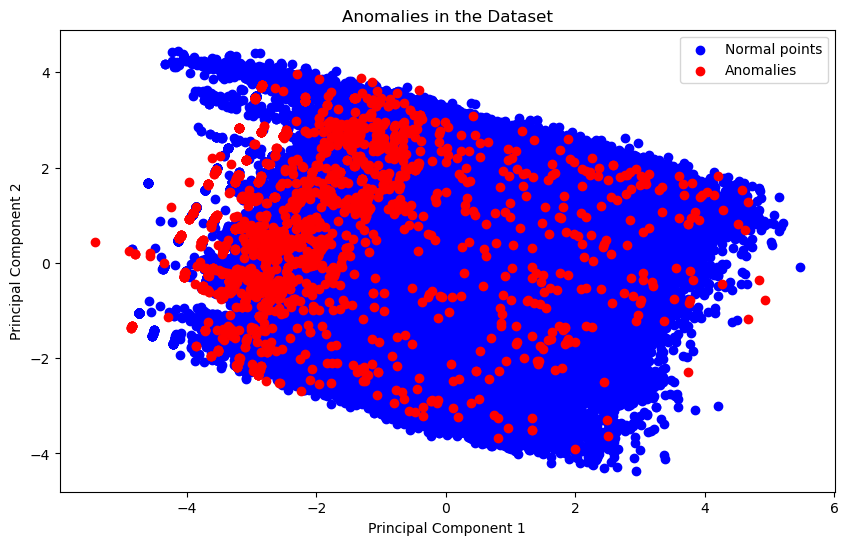

In [95]:
# a) Visualization using PCA
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1)

plt.figure(figsize=(10, 6))
plt.scatter(X1_pca[y_pred_initial == 1, 0], X1_pca[y_pred_initial == 1, 1], 
            color='blue', label='Normal points')
plt.scatter(X1_pca[y_pred_initial == -1, 0], X1_pca[y_pred_initial == -1, 1], 
            color='red', label='Anomalies')
plt.title('Anomalies in the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [69]:
# Initial hyperparameters
best_n_neighbors = initial_n_neighbors
best_leaf_size = initial_leaf_size
best_score = float('inf')

# Define ranges to explore 
n_neighbors_range = [5, 10, 15, 20, 25, 30]
leaf_size_range = [10, 20, 30, 40, 50]

In [71]:
# Adaptive search
for n_neighbors in n_neighbors_range:
    for leaf_size in leaf_size_range:
        # Initialize the LOF model with current parameters
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, leaf_size=leaf_size)
        
        # Fit the model
        y_pred = lof.fit_predict(X1)
        
        # Calculate the average negative outlier factor as a score
        score = np.mean(lof.negative_outlier_factor_)
        
        # If the score is better (lower), update the best parameters
        if score < best_score:
            best_score = score
            best_n_neighbors = n_neighbors
            best_leaf_size = leaf_size
            print(f"Updated Best Params: n_neighbors={n_neighbors}, leaf_size={leaf_size}, score={score}")


In [96]:
# 3. Final LOF model with the best parameters found
lof_best = LocalOutlierFactor(n_neighbors=best_n_neighbors, leaf_size=best_leaf_size)
y_pred_best = lof_best.fit_predict(X1)

In [97]:
# Anomalies detected
anomalies_best = X1[y_pred_best == -1]
print(f"Final Number of Anomalies Detected: {len(anomalies_best)}")

Final Number of Anomalies Detected: 1050


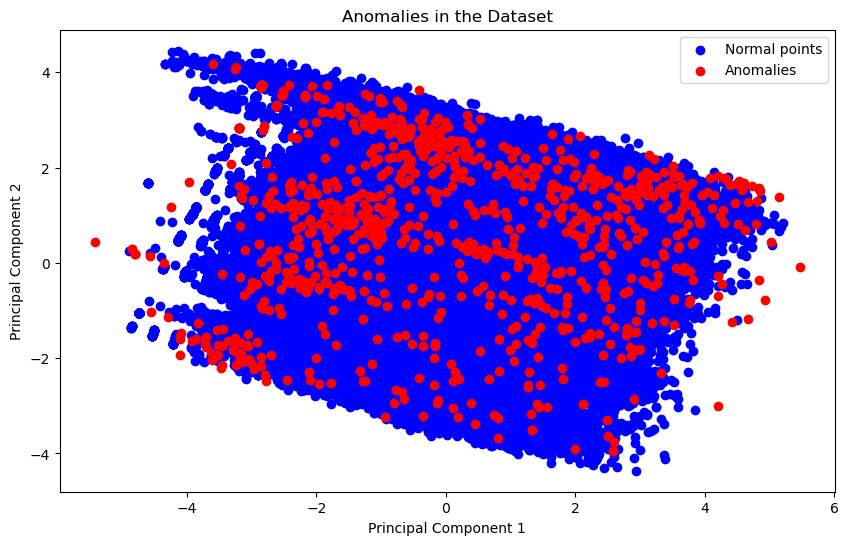

In [98]:
# 4. Evaluation

# a) Visualization using PCA
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1)

plt.figure(figsize=(10, 6))
plt.scatter(X1_pca[y_pred_best == 1, 0], X1_pca[y_pred_best == 1, 1], 
            color='blue', label='Normal points')
plt.scatter(X1_pca[y_pred_best == -1, 0], X1_pca[y_pred_best == -1, 1], 
            color='red', label='Anomalies')
plt.title('Anomalies in the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
# PCA seems to similar to DBSCAN PCA where points are overlapping and is unable to distinguish between normal and anomalous. 

In [107]:
# 5. Variational Autoencoder (VAE)

In [108]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, input_shape, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_shape, latent_dim)
        self.decoder = self.build_decoder(input_shape, latent_dim)
    
    def build_encoder(self, input_shape, latent_dim):
        inputs = layers.Input(shape=input_shape)
        h = layers.Dense(64, activation='relu')(inputs)
        h = layers.Dense(32, activation='relu')(h)
        z_mean = layers.Dense(latent_dim)(h)
        z_log_var = layers.Dense(latent_dim)(h)
        z = Sampling()([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name="encoder")

    def build_decoder(self, input_shape, latent_dim):
        inputs = layers.Input(shape=(latent_dim,))
        h = layers.Dense(32, activation='relu')(inputs)
        h = layers.Dense(64, activation='relu')(h)
        outputs = layers.Dense(input_shape[0], activation='sigmoid')(h)
        return Model(inputs, outputs, name="decoder")
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        outputs = self.decoder(z)
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= inputs.shape[1]
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return outputs

# Define the input shape and latent dimension
input_shape = (X_train.shape[1],)
latent_dim = 2

# Initialize the VAE model
vae = VAE(input_shape, latent_dim)


In [109]:
# Compile the model
vae.compile(optimizer='adam')

# Train the model
epochs = 50
batch_size = 32
vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size)


Epoch 1/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 12.9961
Epoch 2/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 11.4964
Epoch 3/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.3649
Epoch 4/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11.3338
Epoch 5/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.3221
Epoch 6/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11.3254
Epoch 7/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.3037
Epoch 8/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.2712
Epoch 9/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11.3021
Epoch 10/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.2542
Epoch 11/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.2965
Epoch 12/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.2326
Epoch 13/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.2691
Epoch 14/50
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11.2612
Epoch 15/50
177

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


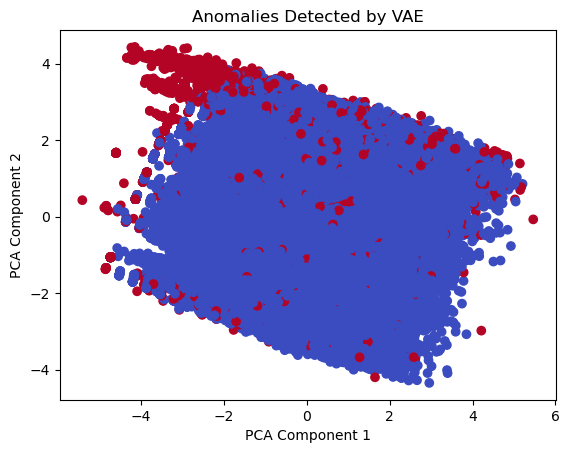

In [110]:
# Predict reconstruction
X_train_reconstructed = vae.predict(X_train)
reconstruction_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies
anomalies = reconstruction_errors > threshold

# Visualize the anomalies using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=anomalies, cmap='coolwarm')
plt.title("Anomalies Detected by VAE")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


1. Visualization:

 • Clustering of Anomalies: The red points in your plot represent detected anomalies, and the blue points represent normal data. Ideally, anomalies should be well-separated from normal points. In your plot, the anomalies are concentrated in the top left corner, indicating that the VAE has identified a distinct group of outliers.
 
 • Spread of Normal Data: The blue points are spread out across the plot, indicating that the normal data has variability but doesn’t overlap significantly with the anomalies.

#### In general, out of all the models that i have explored, Autoencoder is the best. Below are the two reasons:
#### The distribution of reconstruction errors is well-behaved, with a clear distinction between normal points and anomalies. The threshold for detecting anomalies seems appropriate.
#### The PCA visualization shows a good separation between normal and anomalous points, indicating that the autoencoder is effectively detecting diverse anomalies in the dataset.
#### Moreover, it was able to separate anomalies better than the rest of the models.